<a href="https://colab.research.google.com/github/hs-wang17/education/blob/main/2020_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 读取数据

## 0. 安装与配置

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir("/content/gdrive/My Drive/Colab Notebooks/education/2020")

try:
    import shap
except ImportError:
    !pip install shap
    import shap

import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

plt.style.use('ggplot')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 1. 专科毕业生数据

In [ ]:
time_0 = time.time()
df = pd.read_csv('./2020_data/data_j_code.csv', low_memory=False)
print('time of opening csv file: %.4f s' % (time.time() - time_0))
df['A8'].fillna(False)  # 民族
print(df)

time of opening csv file: 4.9201 s
         INDEX   A1     A2    A3   A4   A5  ...  D63  D64  D65  D66  D67  D68
0          693  1.0    1.0  28.0  1.0  1.0  ...  NaN  NaN  NaN  NaN  NaN  NaN
1          694  2.0    1.0  28.0  1.0  1.0  ...  NaN  NaN  NaN  NaN  NaN  NaN
2          695  1.0    1.0  28.0  1.0  1.0  ...  NaN  NaN  NaN  NaN  NaN  NaN
3          696  1.0    1.0  28.0  1.0  1.0  ...  NaN  NaN  NaN  NaN  NaN  NaN
4          697  1.0    1.0  28.0  1.0  1.0  ...  NaN  NaN  NaN  NaN  NaN  NaN
...        ...  ...    ...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
145610  348722  1.0  190.0  26.0  7.0  1.0  ...  NaN  NaN  NaN  NaN  NaN  NaN
145611  348723  1.0  190.0  26.0  7.0  1.0  ...  NaN  NaN  NaN  NaN  NaN  NaN
145612  348724  2.0  190.0  26.0  7.0  1.0  ...  NaN  NaN  NaN  NaN  NaN  NaN
145613  348725  1.0  190.0  26.0  7.0  1.0  ...  NaN  NaN  NaN  NaN  NaN  NaN
145614  348726  2.0  190.0  26.0  7.0  1.0  ...  NaN  NaN  NaN  NaN  NaN  NaN

[145615 rows x 177 columns]


## 2. 本科毕业生数据

In [ ]:
time_0 = time.time()
df = pd.read_csv('./2020_data/data_u_code.csv', low_memory=False)
print('time of opening csv file: %.4f s' % (time.time() - time_0))

time of opening csv file: 6.4807 s


## 3. 硕士毕业生数据

In [ ]:
time_0 = time.time()
df = pd.read_csv('./2020_data/data_m_code.csv', low_memory=False)
print('time of opening csv file: %.4f s' % (time.time() - time_0))

time of opening csv file: 0.3045 s


# 一、工作满意度模型（按学历划分）

Index(['INDEX', 'A1', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11',
       'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21',
       'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31',
       'A32', 'A33', 'A34', 'A35', 'A36', 'A37'],
      dtype='object')
Index(['S1', 'S2', 'S3', 'S4'], dtype='object')
(6671, 37)
Accuracy: 55.0898%


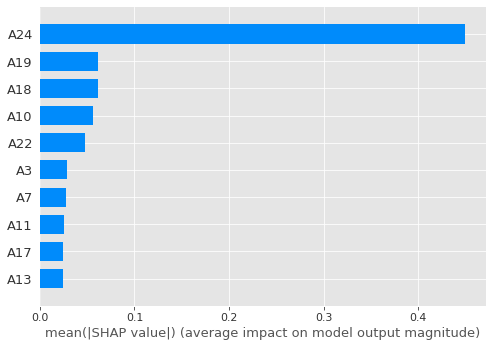

In [ ]:
df = df[df['S1'] > 0]
A, Y_matrix = df.iloc[:, list(range(2)) + list(range(3, 38))], df.iloc[:, range(38, 42)]    # del '学校名称'

print(A.keys())
print(Y_matrix.keys())
print(A.shape)

test_size = 0.05
A_train, A_test, Y_train, Y_test = train_test_split(A, Y_matrix.iloc[:, 0], test_size=test_size)
X_train, X_test = A_train.iloc[:, 1:], A_test.iloc[:, 1:]

# XGBoost Model
model = XGBRegressor(learning_rate=0.1,
                     n_estimators=400,
                     max_depth=8,
                     min_child_weight=1e-3,
                     gamma=0.01,
                     subsample=0.9,
                     scoring='r2',
                     objective ='reg:squarederror')

model.fit(X_train, Y_train, verbose=False, 
          early_stopping_rounds=5, 
          eval_set=[(X_test, Y_test)])

Y_pred = model.predict(X_test)
predictions = [round(value) for value in Y_pred]
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.4f%%" % (accuracy * 100.0))

# SHAP explainer
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, show=False, plot_type='bar', max_display=10)
plt.savefig('./summary/1/1-3.pdf', bbox_inches='tight')
plt.show()

np.save('./summary/1/1-3.npy', shap_values)
pd.DataFrame(np.sort(np.mean(np.abs(shap_values), axis=0))[::-1]).to_excel('./summary/1/1-3.xlsx')

# 二、工作满意度模型（按学科门类/专业大类划分）

Index(['INDEX', 'A1', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11',
       'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21',
       'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31',
       'A32', 'A33', 'A34', 'A35', 'A36', 'A37'],
      dtype='object')
Index(['S1', 'S2', 'S3', 'S4'], dtype='object')
(6671, 37)
Class: 1
Number of Class 1 Student: 1040
Accuracy: 50.0000%


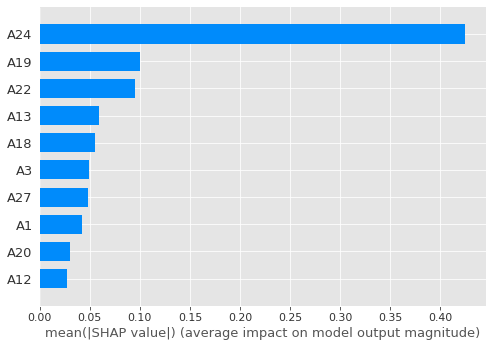

Class: 2
Number of Class 2 Student: 919
Accuracy: 43.4783%


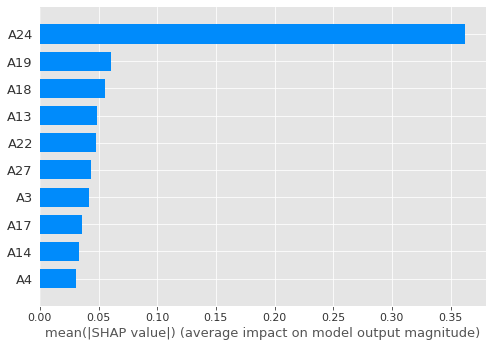

Class: 3
Number of Class 3 Student: 687
Accuracy: 40.0000%


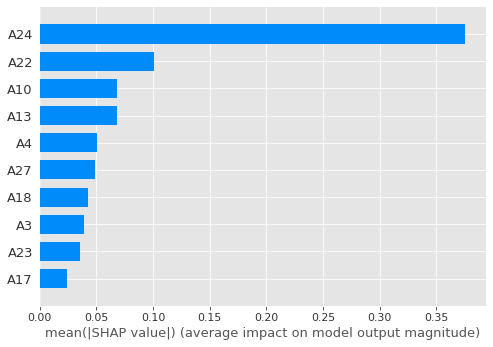

Class: 4
Number of Class 4 Student: 348
Accuracy: 11.1111%


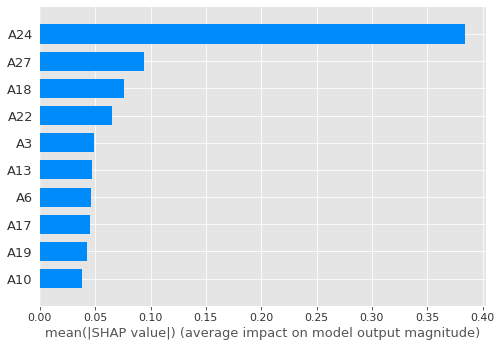

Class: 5
Number of Class 5 Student: 579
Accuracy: 51.7241%


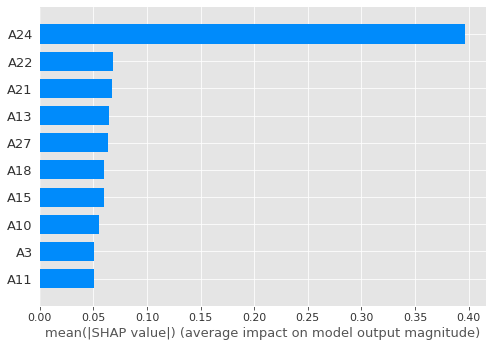

Class: 6
Number of Class 6 Student: 2073
Accuracy: 55.7692%


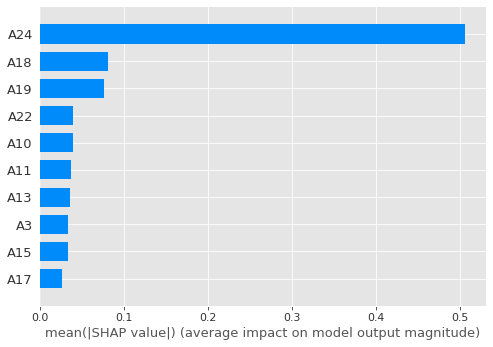

Class: 7
Number of Class 7 Student: 411
Accuracy: 33.3333%


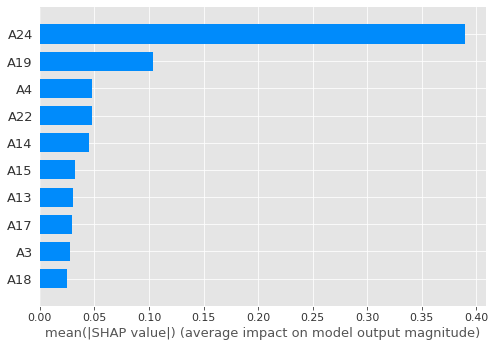

Class: 8
Number of Class 8 Student: 190
Accuracy: 80.0000%


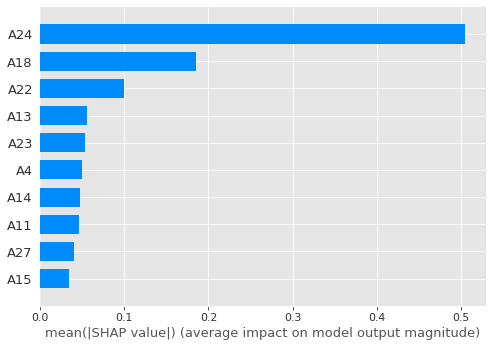

Class: 9
Number of Class 9 Student: 65
Accuracy: 100.0000%


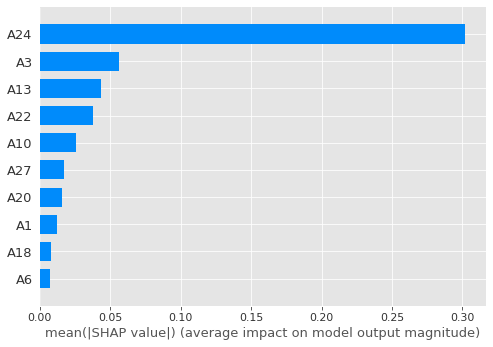

Class: 10
Number of Class 10 Student: 30
Accuracy: 50.0000%


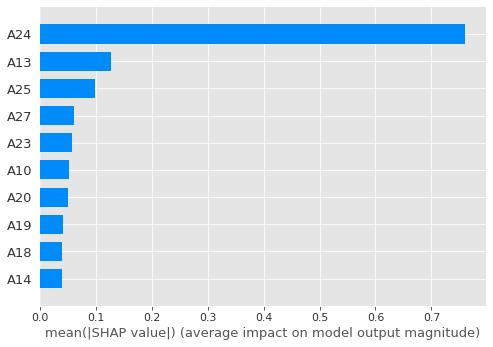

Class: 11
Number of Class 11 Student: 186
Accuracy: 50.0000%


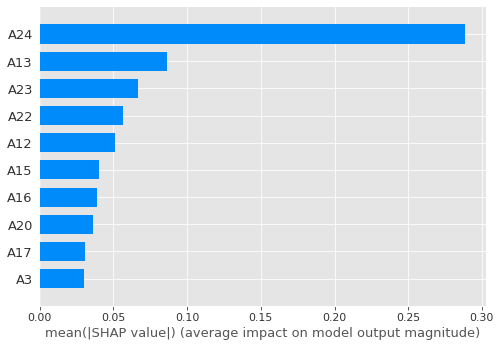

Class: 12
Number of Class 12 Student: 143
Accuracy: 62.5000%


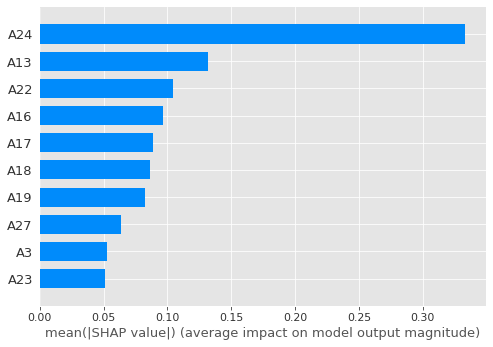

In [ ]:
A, Y_matrix = df.iloc[:, list(range(2)) + list(range(3, 38))], df.iloc[:, range(38, 42)]    # del '学校名称'
B = pd.DataFrame.copy(A, deep=True)   # B is a copy of A

print(A.keys())
print(Y_matrix.keys())
print(A.shape)

for i in range(1, B['A7'].unique().shape[0] + 1):
    print('Class:', i)
    A = B[B['A7'] == i]
    A = A.drop('A7', axis=1)
    Y = Y_matrix.iloc[:, 0][B['A7'] == i]
    print('Number of Class %i Student: %i' % (i, Y.shape[0]))

    test_size = 0.05
    A_train, A_test, Y_train, Y_test = train_test_split(A, Y, test_size=test_size)
    X_train, X_test = A_train.iloc[:, 1:], A_test.iloc[:, 1:]

    model = XGBRegressor(learning_rate=0.1,
                         n_estimators=400,
                         max_depth=8,
                         min_child_weight=1e-3,
                         gamma=0.01,
                         subsample=0.9,
                         scoring='r2',
                         objective ='reg:squarederror')
    
    model.fit(X_train, Y_train, verbose=False,
              early_stopping_rounds=5, 
              eval_set=[(X_test, Y_test)])

    Y_pred = model.predict(X_test)
    predictions = [round(value) for value in Y_pred]
    accuracy = accuracy_score(Y_test, predictions)
    print("Accuracy: %.4f%%" % (accuracy * 100.0))

    # SHAP explainer
    explainer = shap.Explainer(model)
    shap_values = explainer.shap_values(X_train)

    shap.summary_plot(shap_values, X_train, show=False, plot_type='bar', max_display=10)
    plt.savefig('./summary/2/2-3-%i.pdf' % i, bbox_inches='tight')
    plt.show()

    np.save('./summary/2/2-3-%i.npy' % i, shap_values)
    pd.DataFrame(np.sort(np.mean(np.abs(shap_values), axis=0))[::-1]).to_excel('./summary/2/2-3-%i.xlsx' % i)

In [ ]:
A = ['A' + str(i) for i in range(1, 38)]
del A[6], A[1]
A = np.array(A)
shap_abs_mean = np.zeros((12, A.shape[0]))  # 12 or 19

sum = 0
for i in range(1, 13):  # 13 or 20
    shap_ = np.load('./summary/2/2-3-%i.npy' % i)
    shap_abs_mean[i-1] = np.mean(np.abs(shap_), axis=0)
    sum += np.sum(np.abs(shap_), axis=0)

seq = sum.argsort()[20:][::-1]
A_seq = A[seq]
print(A_seq)
shap_abs_mean = pd.DataFrame(np.log(shap_abs_mean / np.max(shap_abs_mean)) + 5)

np.save('./summary/2/2-3.npy', shap_abs_mean)
df = pd.DataFrame(shap_abs_mean.loc[:, seq])
df.to_excel('./summary/2/2-3.xlsx')

['A24' 'A18' 'A19' 'A22' 'A13' 'A27' 'A3' 'A10' 'A17' 'A15' 'A14' 'A11'
 'A23' 'A16' 'A4']


divide by zero encountered in log


# 三、学校满意度模型（按学历划分）

Index(['INDEX', 'A1', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'B1', 'B2', 'B3',
       'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14',
       'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24',
       'B25', 'B26', 'B27', 'B28', 'B29', 'B30', 'B31', 'B32', 'B33', 'B34',
       'B35', 'B36', 'B37', 'B38', 'B39', 'B40', 'B41', 'B42', 'B43'],
      dtype='object')
Index(['S5', 'S6'], dtype='object')
(7513, 51)
Accuracy: 69.6809%


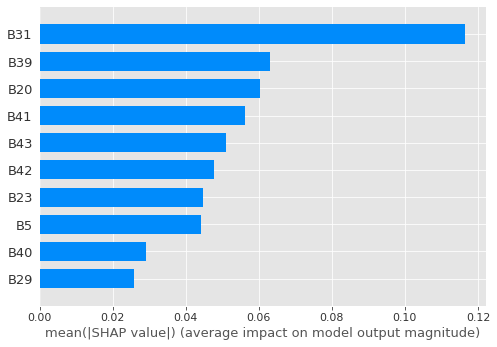

In [ ]:
df = df[df['S5'] > 0]
A, Y_matrix = df.iloc[:, list(range(2)) + list(range(3, 9)) + list(range(42, 85))], df.iloc[:, range(85, 87)]

print(A.keys())
print(Y_matrix.keys())
print(A.shape)

test_size = 0.05
A_train, A_test, Y_train, Y_test = train_test_split(A, Y_matrix.iloc[:, 0], test_size=test_size)
X_train, X_test = A_train.iloc[:, 1:], A_test.iloc[:, 1:]

# XGBoost Model
model = XGBRegressor(learning_rate=0.1,
                     n_estimators=400,
                     max_depth=8,
                     min_child_weight=1e-3,
                     gamma=0.01,
                     subsample=0.9,
                     scoring='r2',
                     objective ='reg:squarederror')

model.fit(X_train, Y_train, verbose=False, 
          early_stopping_rounds=5, 
          eval_set=[(X_test, Y_test)])

Y_pred = model.predict(X_test)
predictions = [round(value) for value in Y_pred]
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.4f%%" % (accuracy * 100.0))

# SHAP explainer
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, show=False, plot_type='bar', max_display=10)
plt.savefig('./summary/3/3-3.pdf', bbox_inches='tight')
plt.show()

np.save('./summary/3/3-3.npy', shap_values)
pd.DataFrame(np.sort(np.mean(np.abs(shap_values), axis=0))[::-1]).to_excel('./summary/3/3-3.xlsx')

# 四、	学校满意度模型（按学校类型划分）


Index(['INDEX', 'A1', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'B1', 'B2', 'B3',
       'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14',
       'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24',
       'B25', 'B26', 'B27', 'B28', 'B29', 'B30', 'B31', 'B32', 'B33', 'B34',
       'B35', 'B36', 'B37', 'B38', 'B39', 'B40', 'B41', 'B42', 'B43'],
      dtype='object')
Index(['S5', 'S6'], dtype='object')
(7513, 51)
Type: 1
Number of Type 1 Student: 1197
Accuracy: 46.6667%


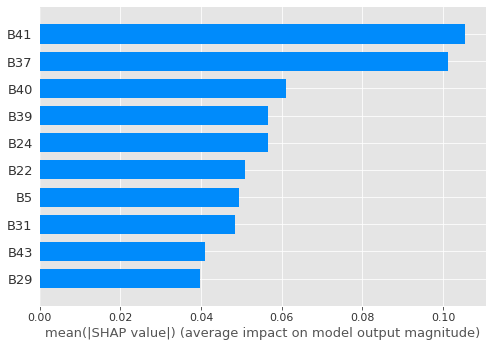

Type: 2
Number of Type 2 Student: 8
Accuracy: 100.0000%


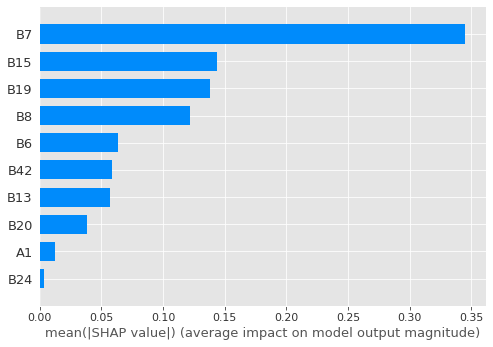

Type: 3
Number of Type 3 Student: 2993
Accuracy: 58.0000%


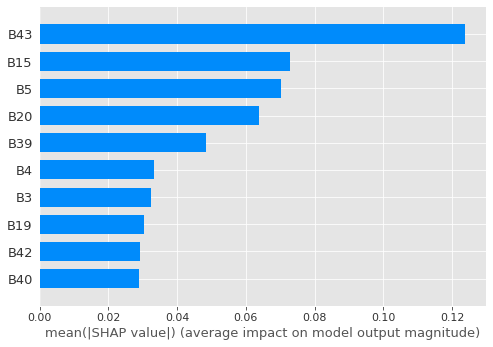

Type: 4
Number of Type 4 Student: 219
Accuracy: 36.3636%


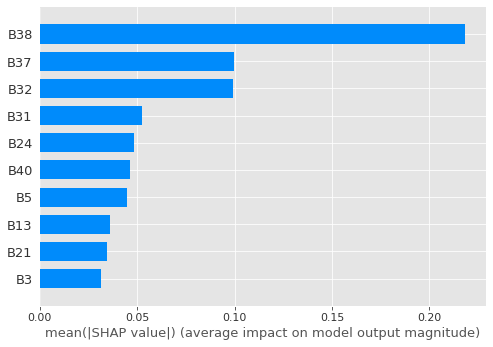

Type: 5
Number of Type 5 Student: 2096
Accuracy: 78.0952%


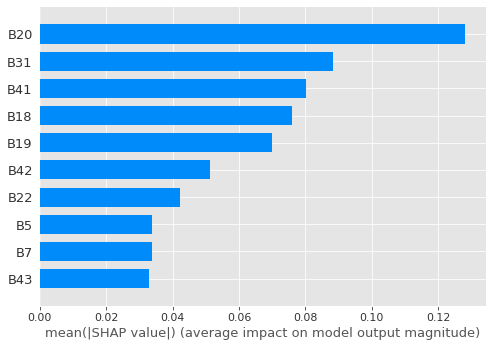

Type: 6
Number of Type 6 Student: 55
Accuracy: 66.6667%


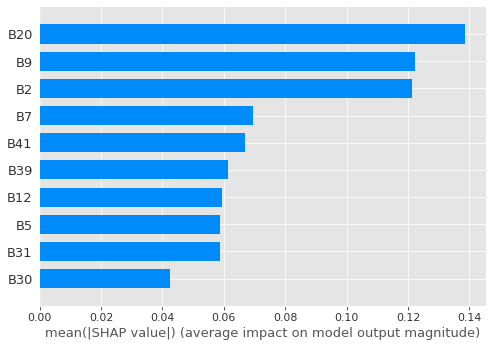

Type: 7
Number of Type 7 Student: 525
Accuracy: 40.7407%


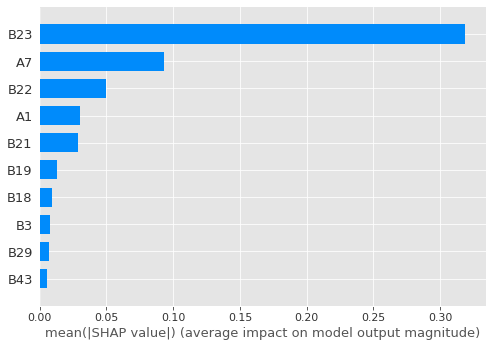

Type: 8
Number of Type 8 Student: 417
Accuracy: 71.4286%


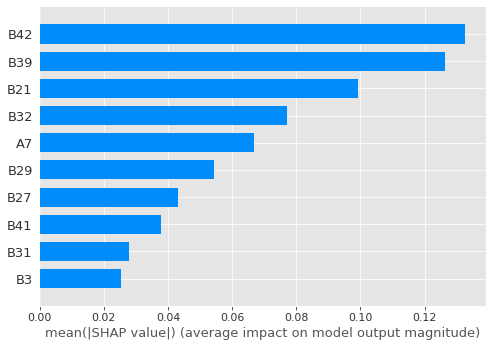

Type: 9
Number of Type 9 Student: 3
Accuracy: 100.0000%


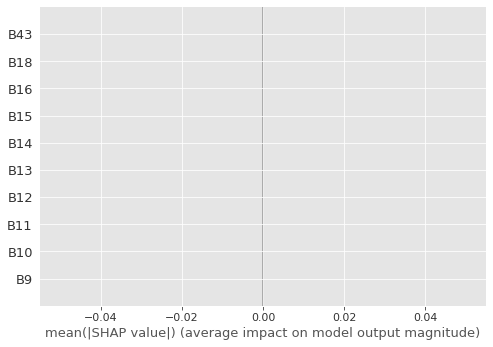

In [ ]:
A, Y_matrix = df.iloc[:, list(range(2)) + list(range(3, 9)) + list(range(42, 85))], df.iloc[:, range(85, 87)]
B = pd.DataFrame.copy(A, deep=True)   # B is a copy of A

print(A.keys())
print(Y_matrix.keys())
print(A.shape)

for i in range(1, B['A4'].unique().shape[0] + 1):
    print('Type:', i)
    A = B[B['A4'] == i]
    A = A.drop('A4', axis=1)
    Y = Y_matrix.iloc[:, 0][B['A4'] == i]
    print('Number of Type %i Student: %i' % (i, Y.shape[0]))

    test_size = 0.05
    A_train, A_test, Y_train, Y_test = train_test_split(A, Y, test_size=test_size)
    X_train, X_test = A_train.iloc[:, 1:], A_test.iloc[:, 1:]

    model = XGBRegressor(learning_rate=0.1,
                         n_estimators=400,
                         max_depth=8,
                         min_child_weight=1e-3,
                         gamma=0.01,
                         subsample=0.9,
                         scoring='r2',
                         objective ='reg:squarederror')
    
    model.fit(X_train, Y_train, verbose=False,
              early_stopping_rounds=5, 
              eval_set=[(X_test, Y_test)])

    Y_pred = model.predict(X_test)
    predictions = [round(value) for value in Y_pred]
    accuracy = accuracy_score(Y_test, predictions)
    print("Accuracy: %.4f%%" % (accuracy * 100.0))

    # SHAP explainer
    explainer = shap.Explainer(model)
    shap_values = explainer.shap_values(X_train)

    shap.summary_plot(shap_values, X_train, show=False, plot_type='bar', max_display=10)
    plt.savefig('./summary/4/4-3-%i.pdf' % i, bbox_inches='tight')
    plt.show()

    np.save('./summary/4/4-3-%i.npy' % i, shap_values)
    pd.DataFrame(np.sort(np.mean(np.abs(shap_values), axis=0))[::-1]).to_excel('./summary/4/4-3-%i.xlsx')

In [ ]:
A = ['A1', 'A3', 'A5', 'A6', 'A7', 'A8', 'B1', 'B2',
     'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13',
     'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23',
     'B24', 'B25', 'B26', 'B27', 'B28', 'B29', 'B30', 'B31', 'B32', 'B33',
     'B34', 'B35', 'B36', 'B37', 'B38', 'B39', 'B40', 'B41', 'B42', 'B43']
A = np.array(A)
shap_abs_mean = np.zeros((9, A.shape[0]))

sum = 0
for i in range(1, 10):
    shap_ = np.load('./summary/4/4-3-%i.npy' % i)
    shap_abs_mean[i-1] = np.mean(np.abs(shap_), axis=0)
    sum += np.sum(np.abs(shap_), axis=0)

seq = sum.argsort()[24:][::-1]
A_seq = A[seq]
print(A_seq)
shap_abs_mean = pd.DataFrame(np.log(1e-2 + shap_abs_mean / np.max(shap_abs_mean)) + 5)

np.save('./summary/4/4-3.npy', shap_abs_mean)
df = pd.DataFrame(shap_abs_mean.loc[:, seq])
df.to_excel('./summary/4/4-3.xlsx')

['B43' 'B20' 'B41' 'B5' 'B39' 'B23' 'B31' 'B42' 'B19' 'B15' 'B40' 'B18'
 'B22' 'B37' 'A7' 'B29' 'B3' 'B21' 'B4' 'B38' 'B24' 'B32' 'B7' 'B30' 'B13']


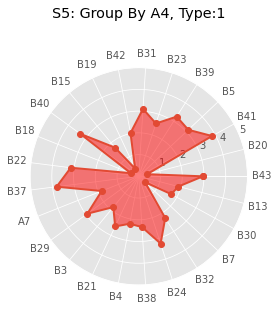

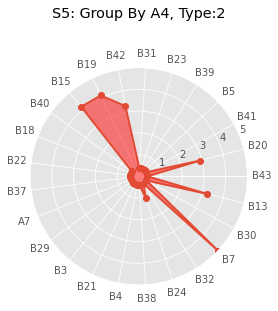

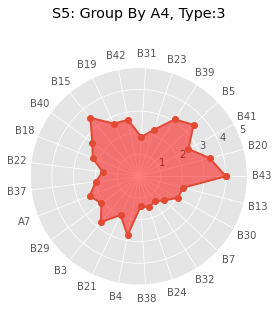

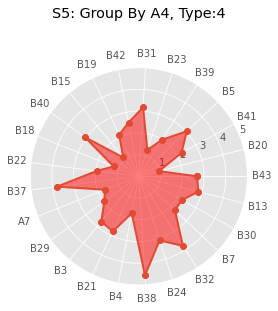

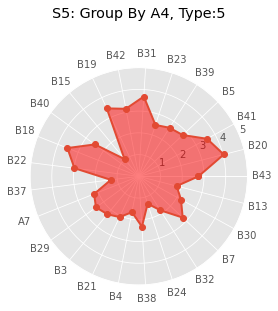

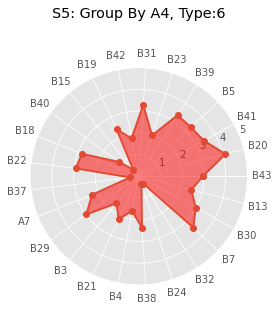

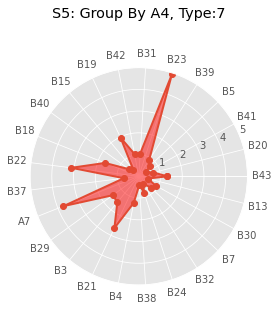

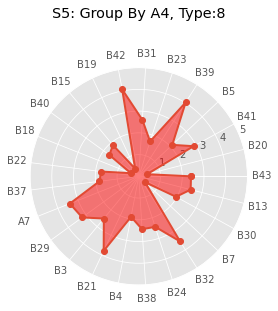

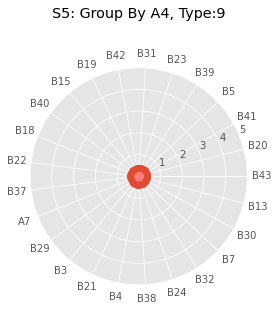

In [ ]:
for i in range(9): # 10 or 11 or 9
    plt.style.use('ggplot')
    feature = A_seq
    values = np.array(shap_abs_mean.loc[i, seq])
    N = values.shape[0]
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
    values = np.concatenate((values, [values[0]]))
    angles = np.concatenate((angles, [angles[0]]))

    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, values, 'o-', linewidth=2, label='Type:%i' % (i + 1))
    ax.fill(angles, values, 'r', alpha=0.5)
    ax.set_thetagrids(angles * 180 / np.pi, feature)
    ax.set_ylim(0, 5)
    plt.title('S5: Group By A4, Type:%i' % (i + 1), y=1.2)
    ax.grid(True)
    plt.savefig('./summary/4/4-3-Type:%i.pdf' % (i + 1), bbox_inches='tight')
    plt.show()

# 五、	学校满意度模型（按学校层次划分）


Index(['INDEX', 'A1', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'B1', 'B2', 'B3',
       'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14',
       'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24',
       'B25', 'B26', 'B27', 'B28', 'B29', 'B30', 'B31', 'B32', 'B33', 'B34',
       'B35', 'B36', 'B37', 'B38', 'B39', 'B40', 'B41', 'B42', 'B43'],
      dtype='object')
Index(['S5', 'S6'], dtype='object')
(7513, 51)
Level: 1
Number of Level 1 Student: 3881
Accuracy: 69.2308%


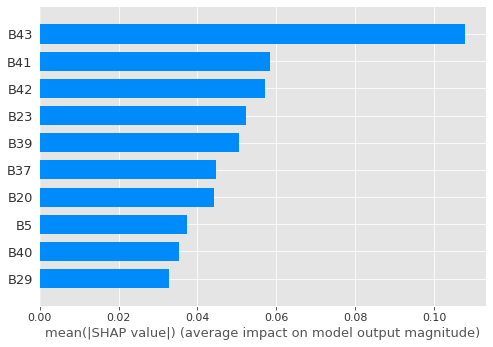

Level: 2
Number of Level 2 Student: 3632
Accuracy: 70.3297%


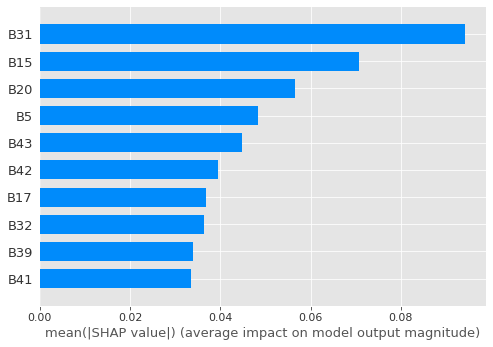

In [ ]:
df = df[df['S5'] > 0]
A, Y_matrix = df.iloc[:, list(range(2)) + list(range(3, 9)) + list(range(42, 85))], df.iloc[:, range(85, 87)]
B = pd.DataFrame.copy(A, deep=True)   # B is a copy of A

print(A.keys())
print(Y_matrix.keys())
print(A.shape)

for i in range(1, B['A6'].unique().shape[0] + 1):
    print('Level:', i)
    A = B[B['A6'] == i]
    A = A.drop('A6', axis=1)
    Y = Y_matrix.iloc[:, 0][B['A6'] == i]
    print('Number of Level %i Student: %i' % (i, Y.shape[0]))

    test_size = 0.05
    A_train, A_test, Y_train, Y_test = train_test_split(A, Y, test_size=test_size)
    X_train, X_test = A_train.iloc[:, 1:], A_test.iloc[:, 1:]

    model = XGBRegressor(learning_rate=0.1,
                         n_estimators=400,
                         max_depth=8,
                         min_child_weight=1e-3,
                         gamma=0.01,
                         subsample=0.9,
                         scoring='r2',
                         objective ='reg:squarederror')
    
    model.fit(X_train, Y_train, verbose=False,
              early_stopping_rounds=5, 
              eval_set=[(X_test, Y_test)])

    Y_pred = model.predict(X_test)
    predictions = [round(value) for value in Y_pred]
    accuracy = accuracy_score(Y_test, predictions)
    print("Accuracy: %.4f%%" % (accuracy * 100.0))

    # SHAP explainer
    explainer = shap.Explainer(model)
    shap_values = explainer.shap_values(X_train)

    shap.summary_plot(shap_values, X_train, show=False, plot_type='bar', max_display=10)
    plt.savefig('./summary/5/5-3-%i.pdf' % i, bbox_inches='tight')
    plt.show()

    np.save('./summary/5/5-3-%i.npy' % i, shap_values)
    pd.DataFrame(np.sort(np.mean(np.abs(shap_values), axis=0))[::-1]).to_excel('./summary/5/5-3-%i.xlsx' % i)

In [ ]:
A = ['A1', 'A3', 'A4', 'A5', 'A7', 'A8', 'B1', 'B2',
     'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13',
     'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23',
     'B24', 'B25', 'B26', 'B27', 'B28', 'B29', 'B30', 'B31', 'B32', 'B33',
     'B34', 'B35', 'B36', 'B37', 'B38', 'B39', 'B40', 'B41', 'B42', 'B43']
A = np.array(A)
shap_abs_mean = np.zeros((2, A.shape[0])) # 2 or 4

sum = 0
for i in range(1, 3):
    shap_ = np.load('./summary/5/5-3-%i.npy' % i)
    shap_abs_mean[i-1] = np.mean(np.abs(shap_), axis=0)
    sum += np.sum(np.abs(shap_), axis=0)

seq = sum.argsort()[24:][::-1]
A_seq = A[seq]
print(A_seq)
shap_abs_mean = pd.DataFrame(np.log(1e-2 + shap_abs_mean / np.max(shap_abs_mean)) + 5)

np.save('./summary/5/5-3.npy', shap_abs_mean)
df = pd.DataFrame(shap_abs_mean.loc[:, seq])
df.to_excel('./summary/5/5-3.xlsx')

['B43' 'B31' 'B20' 'B42' 'B41' 'B5' 'B39' 'B23' 'B15' 'B37' 'B40' 'B29'
 'B19' 'B32' 'B18' 'B17' 'A3' 'A7' 'B21' 'B22' 'B3' 'B7' 'B30' 'B4' 'B9']


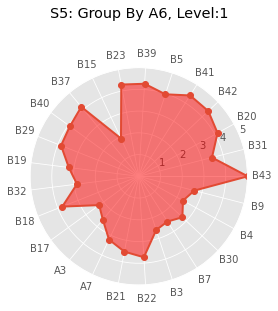

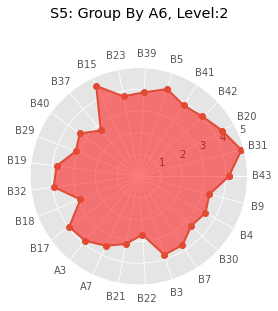

In [ ]:
for i in range(2):  # 2 or 4
    feature = A_seq
    values = np.array(shap_abs_mean.loc[i, seq])
    N = values.shape[0]
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
    values = np.concatenate((values, [values[0]]))
    angles = np.concatenate((angles, [angles[0]]))

    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, values, 'o-', linewidth=2, label='Level:%i' % (i + 1))
    ax.fill(angles, values, 'r', alpha=0.5)
    ax.set_thetagrids(angles * 180 / np.pi, feature)
    ax.set_ylim(0, 5)
    plt.title('S5: Group By A6, Level:%i' % (i + 1), y=1.2)
    ax.grid(True)
    plt.savefig('./summary/5/5-3-Level:%i.pdf' % (i + 1), bbox_inches='tight')
    plt.show()

# 六、就业疫情影响模型（按学历划分）

Index(['INDEX', 'A1', 'A4', 'A5', 'A6', 'A7', 'A8', 'A18', 'B1', 'B2', 'B3',
       'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14',
       'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24',
       'B25', 'B26', 'B27', 'B28', 'B29', 'B30', 'B31', 'B32', 'B33', 'B34',
       'B35', 'B36', 'B37', 'B38', 'B39', 'B40', 'B41', 'B42', 'B43'],
      dtype='object')
Index(['A19', 'A20', 'A21'], dtype='object')
(6156, 51)
Accuracy: 34.0909%


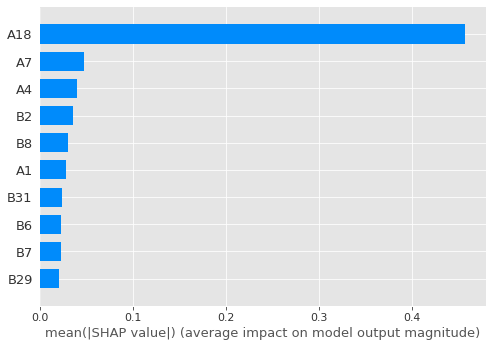

Accuracy: 43.8312%


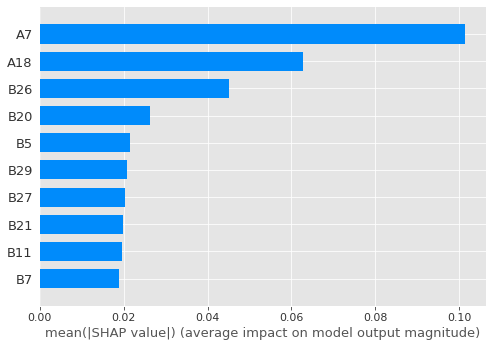

Accuracy: 41.5584%


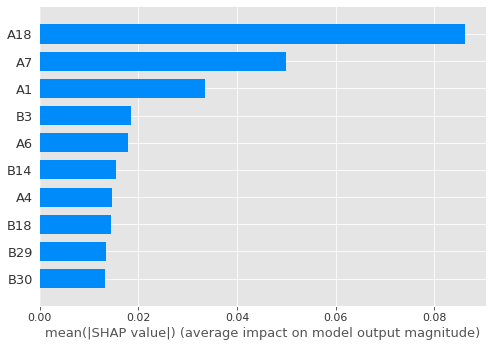

In [ ]:
df = df[df['A19'] > 0]
df = df[df['A20'] > 0]
df = df[df['A21'] > 0]
A, Y_matrix = df.iloc[:, [0, 1] + list(range(4, 9)) + [18] + list(range(42, 85))], df.iloc[:, range(19, 22)]

print(A.keys())
print(Y_matrix.keys())
print(A.shape)

for i in range(3):
    Y = Y_matrix.iloc[:, i]

    test_size = 0.05
    A_train, A_test, Y_train, Y_test = train_test_split(A, Y, test_size=test_size)
    X_train, X_test = A_train.iloc[:, 1:], A_test.iloc[:, 1:]

    # XGBoost Model
    model = XGBRegressor(learning_rate=0.1,
                         n_estimators=400,
                         max_depth=8,
                         min_child_weight=1e-3,
                         gamma=0.01,
                         subsample=0.9,
                         scoring='r2',
                         objective ='reg:squarederror')

    model.fit(X_train, Y_train, verbose=False, 
            early_stopping_rounds=5, 
            eval_set=[(X_test, Y_test)])

    Y_pred = model.predict(X_test)
    predictions = [round(value) for value in Y_pred]
    accuracy = accuracy_score(Y_test, predictions)
    print("Accuracy: %.4f%%" % (accuracy * 100.0))

    # SHAP explainer
    explainer = shap.Explainer(model)
    shap_values = explainer.shap_values(X_train)

    shap.summary_plot(shap_values, X_train, show=False, plot_type='bar', max_display=10)
    plt.savefig('./summary/6/6-3-%i.pdf' % i, bbox_inches='tight')
    plt.show()

    np.save('./summary/6/6-3-%i.npy' % i, shap_values)
    pd.DataFrame(np.sort(np.mean(np.abs(shap_values), axis=0))[::-1]).to_excel('./summary/6/6-3-%i.xlsx' % i)

# 七、能力评估模型（按学历划分）

In [ ]:
ability = df.iloc[:, [0] + list(range(87, 109))]
phenomenon = df.iloc[:, range(109, df.shape[1])]
print(ability.keys())
print(phenomenon.keys())

Index(['INDEX', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22'],
      dtype='object')
Index(['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11',
       'D12', 'D13', 'D14', 'D15', 'D16', 'D17', 'D18', 'D19', 'D20', 'D21',
       'D22', 'D23', 'D24', 'D25', 'D26', 'D27', 'D28', 'D29', 'D30', 'D31',
       'D32', 'D33', 'D34', 'D35', 'D36', 'D37', 'D38', 'D39', 'D40', 'D41',
       'D42', 'D43', 'D44', 'D45', 'D46', 'D47', 'D48', 'D49', 'D50', 'D51',
       'D52', 'D53', 'D54', 'D55', 'D56', 'D57', 'D58', 'D59', 'D60', 'D61',
       'D62', 'D63', 'D64', 'D65', 'D66', 'D67', 'D68'],
      dtype='object')


In [ ]:
def ab_ph(i):
    if i < 1 or i >= 23:
        return []
    ap = np.array([1, 3, 5, 7, 9, 14, 19, 21, 23, 26, 28, 30, 33, 35, 37, 40, 44, 48, 52, 58, 64, 66, 69])
    s, s_ = ap[i-1], ap[i]
    l = []
    for j in range(s, s_):
        l.append('D'+str(j))
    return l

In [ ]:
score = pd.DataFrame(columns=['Num', 'Avg', 'Std'], index=['C'+str(i) for i in range(1, 23)])

for ab in ability.keys()[1:]:
    n = int(ab[1:])
    s = ab_ph(n)
    p = df[df[ab] == 1][s].dropna(axis=0)
    num = p.shape[0]
    avg = p.mean(axis=0).mean()
    std = np.sqrt(((p - avg) ** 2).mean().mean())
    score.iloc[n-1, 0] = num
    score.iloc[n-1, 1] = avg
    score.iloc[n-1, 2] = std

score['Num'] = (score['Num'] - score['Num'].mean()) / score['Num'].std() 
score['Num'] *= 3 / score['Num'].abs().max()
score['Avg'] = (score['Avg'] - score['Avg'].mean()) / score['Avg'].std()
score['Avg'] *= 3 / score['Avg'].abs().max()
print(score.sort_values(by='Avg'))
score.sort_values(by='Avg').to_excel('./summary/7/7-3.xlsx')

           Num        Avg       Std
C14   -1.22907         -3   1.28173
C13  -0.590557    -2.6904   1.07814
C16  -0.812507   -2.64257   1.26994
C20   -1.18971   -2.37266   1.12782
C17   -1.14598   -1.99084   1.11506
C22  -0.868268  -0.863146   1.10864
C19   -1.20393  -0.832692   1.19539
C6     1.43432  -0.376607   1.01964
C7   0.0698252  -0.160963   1.15419
C2     1.13584 -0.0884233   1.12441
C18  -0.964483   0.613509  0.969441
C11  -0.812507   0.621213   0.90739
C12  -0.481223    0.63181  0.852821
C21    -1.1755    0.84831  0.830608
C8     1.87057   0.927846  0.803731
C5           3    1.20695  0.868517
C10  -0.960109    1.28721  0.893583
C4  -0.0887103    1.34317  0.994053
C15 -0.0996438    1.41561  0.794258
C1     2.38772    1.72366  0.926354
C3    0.984958    1.78638  0.856937
C9    0.738955    2.61264  0.728949


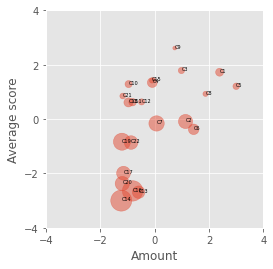

In [ ]:
x = np.array(score['Num'])
y = np.array(score['Avg'])
s = list((np.array(score['Std'])) ** 6 * 100)
plt.scatter(x, y, s=s, alpha=0.5)
plt.xlim((-4, 4))
plt.ylim((-4, 4))
plt.xticks(range(-4, 5, 2))
plt.yticks(range(-4, 5, 2))
ax = plt.gca()
ax.set_aspect(1)
plt.xlabel('Amount')
plt.ylabel('Average score')
for i in range(len(x)):
    ax.text(x[i], y[i], 'C' + str(i+1), fontdict={'fontsize': 5})
plt.savefig('./summary/7/7-3.pdf', bbox_inches='tight')
plt.show()